In [1]:
# We check the CMIP6 snow data availability
from climaf.api import *

Climaf version = 1.2.10
Cache directory set to : /data/mmenegoz/climafcache (use $CLIMAF_CACHE if set) 
Cache directory for remote data set to : /data/mmenegoz/climafcache/remote_data (use $CLIMAF_REMOTE_CACHE if set) 
error    : 'When defining cyearpctl : duplicate declaration for input #0'
error    : 'When defining cyearpctl : duplicate declaration for input #0'
Available macros read from ~/.climaf.macros are : []


In [2]:
# Some arguments
length_trend=30
period_extract='*'

In [3]:
# IPSL 31 members, that should be done only for Northern hemisphere
req_snow = ds(project='CMIP6', model='IPSL-CM6A-LR',
#              variable='snc', table="LImon",frequency='monthly',realization='*',
              variable='snc', table="LImon",frequency='monthly',
               period=period_extract,experiment='piControl',domain=[25,90,-180,180])

In [4]:
req_snow.explore('resolve')

ds('CMIP6%%snc%1850-3049%[25, 90, -180, 180]%/bdd%IPSL-CM6A-LR%IPSL%CMIP%LImon%piControl%r1i1p1f1%gr%latest')

In [5]:
piControl_snow = req_snow.explore('resolve')

In [6]:
# Define a CDO function
cscript("ensavg","cdo ensavg ${mmin} ${out}")

CliMAF operator : ensavg

In [7]:
# Check the data producing a map with CLIMAF
MAM_ens_piControl = clim_average(piControl_snow,'MAM')
ens_avg_snow=ensavg(MAM_ens_piControl)
reduced_map=llbox(ens_avg_snow, lonmin=-180, lonmax=180, latmin=25, latmax=90)

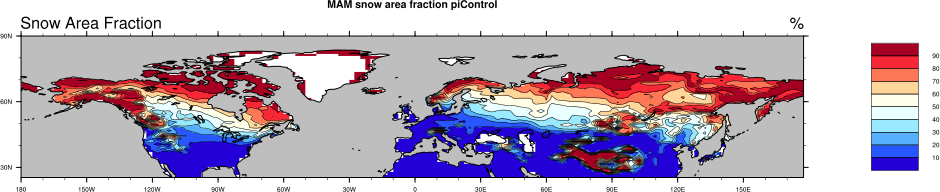

In [8]:
pp = dict(focus='land', contours=1,title='MAM snow area fraction piControl')
myplot = plot(reduced_map,**pp)
iplot(myplot)

In [9]:
# Check the type of climaf data
type(req_snow), type(piControl_snow), type(reduced_map), type(plot(reduced_map,**pp))

(instance, instance, instance, instance)

In [10]:
# We import standard python libraries, in particular because we are not using only CLIMAF
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy import stats
#Activate plots visualization on ipython
%matplotlib inline

In [11]:
# Monthly mean
monthly_snow=ccdo(piControl_snow,operator='monmean')

In [12]:
# Extract March and April
march_snow=ccdo(monthly_snow,operator='selmon,3')
april_snow=ccdo(monthly_snow,operator='selmon,4')

In [13]:
# Spatial average
march_snow_bis=space_average(march_snow)
april_snow_bis=space_average(april_snow)

In [14]:
# climaf.classes.cens --> dictionary
march_snow_ter=cMA(march_snow_bis)
april_snow_ter=cMA(april_snow_bis)

In [15]:
type(req_snow), type(march_snow_bis), type(march_snow_ter)

(instance, instance, numpy.ma.core.MaskedArray)

In [16]:
march_snow_ter.shape, len(march_snow_ter)

((1200, 1, 1), 1200)

In [17]:
subperiods=march_snow_ter.shape[0]/length_trend
subperiods

40

In [18]:
# Initializing march-april arrays
march_april_snow=np.full([subperiods,length_trend], np.nan)
march_april_snow_trend=np.full([subperiods],np.nan)
march_april_snow_pvalue=np.full([subperiods],np.nan)
march_april_snow_intercept=np.full([subperiods],np.nan)
march_april_snow_ideal=np.full([subperiods,length_trend], np.nan)
nb_years=march_snow_ter.shape[0]

In [19]:
march_april_snow.shape, march_april_snow_trend.shape, nb_years, march_snow_ter.shape

((40, 30), (40,), 1200, (1200, 1, 1))

In [20]:
#for num_memb in range(subperiods):
#    memb=num_memb*length_trend
#    print(num_memb)

In [21]:
# Compute hemispheric trends and linear regressions
for num_memb in range(subperiods):
    memb=num_memb*length_trend
    #print(memb)
    tmp=np.stack((march_snow_ter[memb:memb+length_trend,0,0],april_snow_ter[memb:memb+length_trend,0,0]),axis=1)
    march_april_snow[num_memb,:]=np.average(tmp,axis=1)
    tmp_stat=stats.linregress(range(march_april_snow.shape[1]),march_april_snow[num_memb,:])
    march_april_snow_trend[num_memb]=tmp_stat.slope
    march_april_snow_pvalue[num_memb]=tmp_stat.pvalue
    march_april_snow_intercept[num_memb]=tmp_stat.intercept
    march_april_snow_ideal[num_memb,:]=march_april_snow_intercept[num_memb]+\
    march_april_snow_trend[num_memb]*np.arange(length_trend)

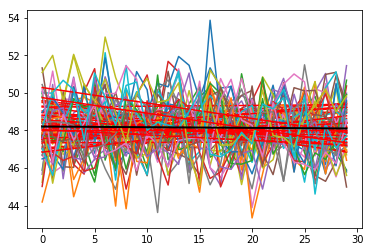

In [22]:
for num_memb in range(subperiods):
    plt.plot(march_april_snow[num_memb,:])
    plt.plot(march_april_snow_ideal[num_memb,:], 'r', label=num_memb)
plt.plot(np.mean(march_april_snow_ideal,axis=0), color='black', linewidth=2)

In [23]:
fit_piControl = stats.norm.pdf(march_april_snow_trend, np.mean(march_april_snow_trend), np.std(march_april_snow_trend))  

In [24]:
march_april_snow_trend.shape, fit_piControl.shape

((40,), (40,))

In [25]:
h=sorted(march_april_snow_trend)#/subperiods)
#mu=np.mean(march_april_snow_trend)#/subperiods
#sigma=np.std(march_april_snow_trend)#/subperiods
#mu, sigma
# Fit a normal distribution to the data:
mu, std = stats.norm.fit(h)
mu, std

(-0.0034636883422715778, 0.042695913660769094)

(-0.09215698424647992, 0.07435932193369967)

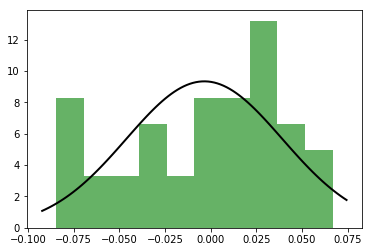

In [26]:
# Plot the histogram.
plt.hist(h, bins=10, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
#title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
#plt.title(title)
xmin, xmax

In [27]:
np.savez('save_snow_piControl_30y_trend.npz', march_april_snow_piControl=march_april_snow, \
         march_april_snow_trend_piControl=march_april_snow_trend,\
         mu=mu,std=std)